<a href="https://colab.research.google.com/github/Mahsa-Goudarzi/ComputerVision/blob/main/M3_Image%20Classification/Exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODULE 3: IMAGE CLASSIFICATION



# **EXERCISE 4**

Connecting to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Generate synthetic image with random blobs

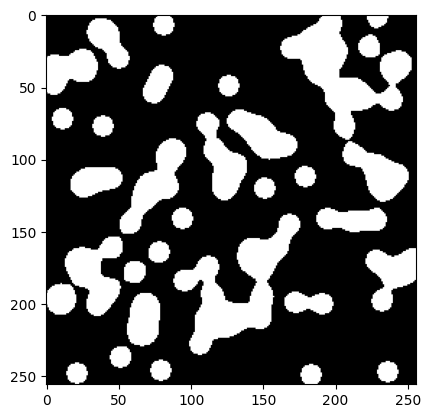

In [1]:
import matplotlib.pyplot as plt
from skimage.data import binary_blobs

# Generate binary blobs image
image = binary_blobs(length=256, volume_fraction=0.3, rng=42)

plt.imshow(image, cmap='gray')
plt.show()

# 2. Object segmentation and labeling

- Segmentation of blobs using Otsu's optimal threshold
- Labeling connected regions
- Visualization



/usr/local/lib/python3.11/dist-packages/skimage/exposure/exposure.py:306: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  hist, bin_edges = np.histogram(image, bins=bins, range=hist_range)


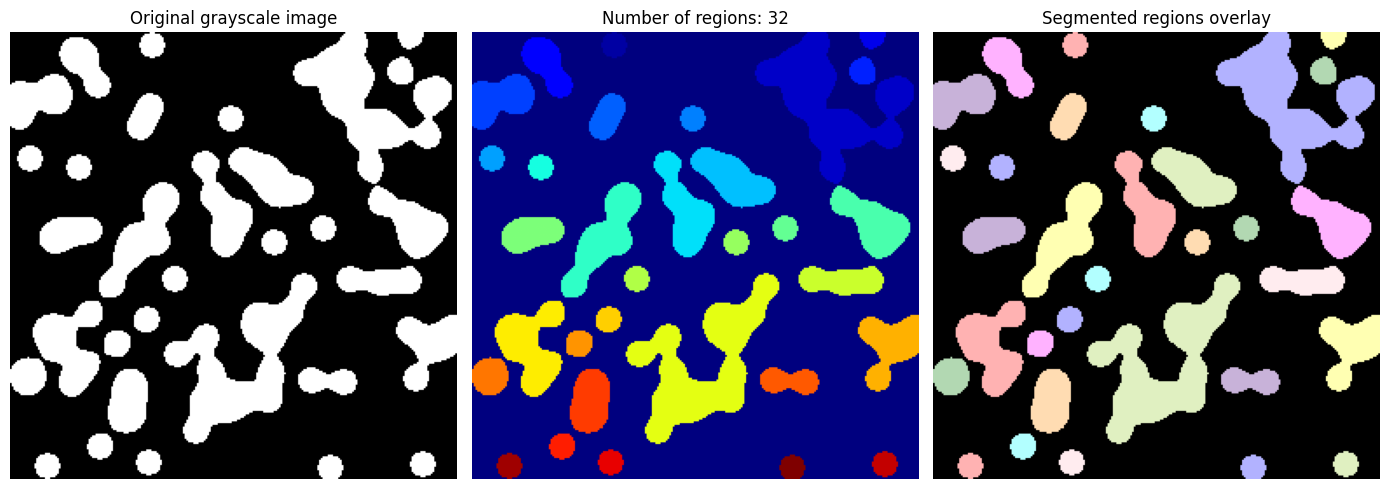

In [2]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io

from skimage import data
from skimage.filters import threshold_otsu
from skimage.measure import label
from skimage.color import label2rgb

thresh = threshold_otsu(image)
bw = image > thresh # keep lighter regions with grayscale intensities above threshold

# label image regions:
label_image, nregions = label(bw,return_num=True)
image_label_overlay = label2rgb(label_image, image=image)

# Get some figures:
fig, axes = plt.subplots(1,3,figsize=(14, 9))
ax = axes.ravel()
ax[0].imshow(image,cmap=plt.cm.gray)
ax[0].set_title('Original grayscale image')
ax[1].imshow(label_image,cmap=plt.cm.jet)
ax[1].set_title('Number of regions: {}'.format(nregions)) # set figure title
ax[2].imshow(image_label_overlay,cmap=plt.cm.jet)
ax[2].set_title('Segmented regions overlay')

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.tight_layout()
plt.show()

# 3. Get regional properties in a pandas dataframe

Function documentation with a list of available attributes can be found at https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops_table


In [3]:
from skimage.measure import regionprops
import pandas as pd
from skimage import measure

properties = measure.regionprops_table(label_image,properties=['label','area','eccentricity','extent','axis_major_length'])

df_features = pd.DataFrame(properties)
df_features.head()

,label,area,eccentricity,extent,axis_major_length
0,1,169.0,0.000000,0.751111,14.679213
1,2,2977.0,0.755218,0.376026,98.161559
2,3,116.0,0.736219,0.773333,15.175575
3,4,594.0,0.885234,0.565714,41.613720
4,5,191.0,0.343427,0.795833,16.139289


Represent area of the blobs as a function of the major axis length

<Axes: xlabel='axis_major_length', ylabel='area'>

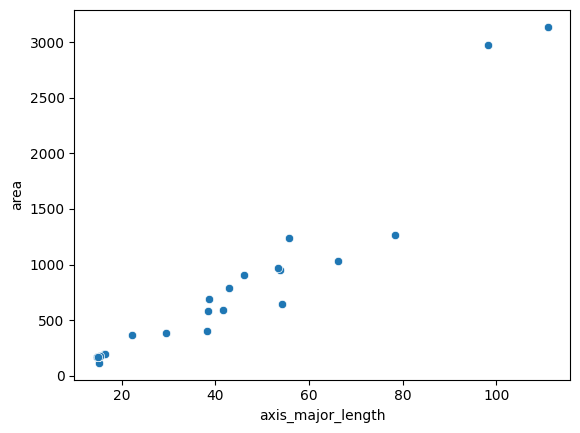

In [4]:
import seaborn as sns

sns.scatterplot(x='axis_major_length',y='area',data=df_features)

Clear correlation between blob's length and area can be observed

#4. Analyze blobs


Since you have the feature data in a pandas dataframe, you can exploit all the functions of te libraries. For instance:

How many blobs have an area above the average?

In [7]:
# Calculate the average area
average_area = df_features['area'].mean()

# Filter blobs with area greater than average
blobs_above_avg = df_features[df_features['area'] > average_area]

blobs_above_avg

,label,area,eccentricity,extent,axis_major_length
1,2,2977.0,0.755218,0.376026,98.161559
5,6,786.0,0.797524,0.682292,42.818271
9,10,953.0,0.900615,0.555685,53.815980
10,11,1032.0,0.929125,0.483372,66.262939
12,13,1269.0,0.954562,0.417984,78.289548
13,14,969.0,0.867219,0.501553,53.390874
18,19,649.0,0.954627,0.779112,54.259698
19,20,3139.0,0.836218,0.363984,111.035914
20,21,1239.0,0.722868,0.563182,55.756014
22,23,906.0,0.680859,0.588312,46.089832


In [8]:
# Count them
num_blobs_above_avg = len(blobs_above_avg)

print(f"there are {num_blobs_above_avg} blobs with an area larger or equal the mean area {average_area}")

there are 11 blobs with an area larger or equal the mean area 614.40625


Represent the blobs that have an area smaller than the average blob's area

In [14]:
# Filter blobs with area greater than average
blobs_below_avg = df_features[df_features['area'] <= average_area]

# Count them
num_blobs_below_avg = len(blobs_below_avg)

print(f"there are {num_blobs_below_avg} blobs with an area larger or equal the mean area {average_area}")

there are 21 blobs with an area larger or equal the mean area 614.40625


find the labels of small and large blobs

In [15]:
print(f"labels of small blobs: {blobs_below_avg['label'].to_numpy()}")
print(f"labels of large blobs: {blobs_above_avg['label'].to_numpy()}")

labels of small blobs: [ 1  3  4  5  7  8  9 12 15 16 17 18 22 24 25 26 28 29 30 31 32]
labels of large blobs: [ 2  6 10 11 13 14 19 20 21 23 27]


Create a binary mask with the large and small blobs

In [16]:
import numpy as np

# Create binary masks (same shape as label_image)
mask_large = np.isin(label_image, blobs_above_avg)
mask_small = np.isin(label_image, blobs_below_avg)

# convert to uint8 (0 and 1)
mask_large = mask_large.astype(np.uint8)
mask_small = mask_small.astype(np.uint8)

Represent the large and small blobs

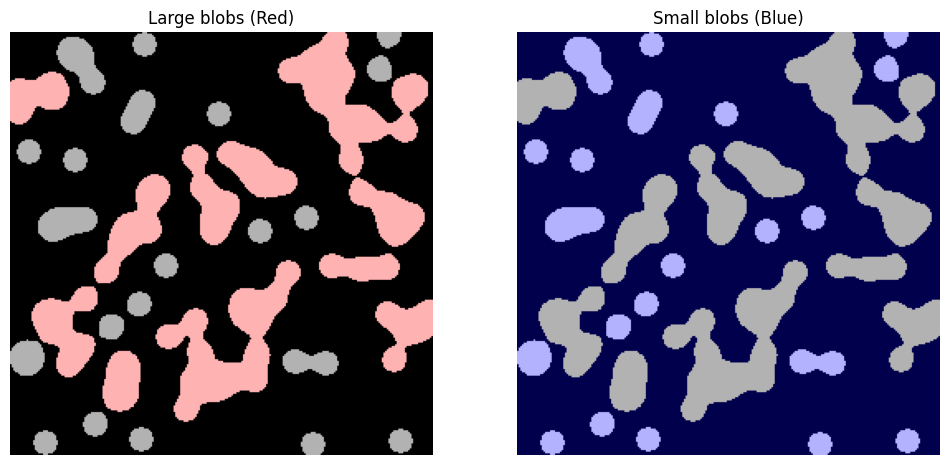

In [18]:
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Overlay large blobs in red on the grayscale image
image_large = label2rgb(mask_large, image=image, bg_label=0, colors=['red'])

# Overlay small blobs in blue on the grayscale image
image_small = label2rgb(mask_small, image=image, bg_label=0, colors=['blue'])

# Display side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image_large)
ax[0].set_title('Large blobs (Red)')
ax[0].axis('off')

ax[1].imshow(image_small)
ax[1].set_title('Small blobs (Blue)')
ax[1].axis('off')

plt.show()


#5. Obtain texture-based regional properties

For the original image

In [20]:
from skimage.feature.texture import graycomatrix, graycoprops

img = np.array([[0, 0, 1, 1],[0, 0, 1, 1],[0, 2, 2, 2],[2, 2, 3, 3]], dtype=np.uint8)
g = graycomatrix(img, [1], [0], levels=4, normed=False, symmetric=False)
print(img)
print('Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,0,0,0]))
print('Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[0,1,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,2,0,0]))
print('Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): {}'.format(g[2,0,0,0]))

[[0 0 1 1]
 [0 0 1 1]
 [0 2 2 2]
 [2 2 3 3]]
Number of times that a grayscale level zero has a neighbour with value zero at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level zero has a neighbour with value 1 at a distance of 1 pixel to the right (angle equal zero): 2
Number of times that a grayscale level 2 has a neighbour with value 2 at a distance of 1 pixel to the right (angle equal zero): 3
Number of times that a grayscale level 2 has a neighbour with value 0 at a distance of 1 pixel to the right (angle equal zero): 0


In [23]:
props = regionprops(label_image,intensity_image=image)

nregions = len(props)

iregion = 0
props_texture = np.zeros((nregions,5))
for p in props:
    minr, minc, maxr, maxc = p.bbox
    I = image[minc:maxc,minr:maxr]
    g = graycomatrix(I, [1], [0], levels=4, normed=True, symmetric=True)
    contrast = graycoprops(g, 'contrast')
    dissimilarity = graycoprops(g, 'dissimilarity')
    homogeneity = graycoprops(g, 'homogeneity')
    energy = graycoprops(g, 'energy')
    correlation = graycoprops(g, 'correlation')

    props_texture[iregion,0] = contrast
    props_texture[iregion,1] = dissimilarity
    props_texture[iregion,2] = homogeneity
    props_texture[iregion,3] = energy
    props_texture[iregion,4] = correlation

    iregion = iregion + 1

# Export to Excel file
df = pd.DataFrame(props_texture, columns=['Contrast', 'Dissimilarity', 'Homogeneity', 'Energy', 'Correlation'])
df.to_excel("Texture_features.xlsx", index=False)
df

<ipython-input-23-5e7e7f96c7a4>:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,0] = contrast
<ipython-input-23-5e7e7f96c7a4>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,1] = dissimilarity
<ipython-input-23-5e7e7f96c7a4>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  props_texture[iregion,2] = homogeneity
<ipython-input-23-5e7e7f96c7a4>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is

,Contrast,Dissimilarity,Homogeneity,Energy,Correlation
0,0.033333,0.033333,0.983333,0.785952,0.904777
1,0.042806,0.042806,0.978597,0.697550,0.909396
2,0.000000,0.000000,1.000000,1.000000,1.000000
3,0.033333,0.033333,0.983333,0.711334,0.927816
4,0.000000,0.000000,1.000000,1.000000,1.000000
5,0.060036,0.060036,0.969982,0.681902,0.874554
6,0.031136,0.031136,0.984432,0.767724,0.918158
7,0.014286,0.014286,0.992857,0.925936,0.888879
8,0.047619,0.047619,0.976190,0.786075,0.858586
9,0.042017,0.042017,0.978992,0.738254,0.898689
